<a href="https://colab.research.google.com/github/jvallalta/ia3/blob/main/CNN_SM_1D_3ch_tf2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#from __future__ import absolute_import, division, print_function, unicode_literals
# Installa TensorFlow
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)


2.3.0


In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D
import numpy as np

Para leer datos lo mejor es usar la toolbox pandas

Los datos se han sacado de:
https://www.kaggle.com/borismarjanovic/price-volume-data-for-all-us-stocks-etfs/version/3

In [3]:
import pandas as pd

# Leer los datos 
# En local: tenemos que tener el fichero en la misma carpeta que el notebook (o cambiar la ruta)
# En Colab: abre la carpeta (usando el boton de la izquierda) y arrastralos dentro desde tu ordenador.

dd_googl = pd.read_csv("googl.us.txt", delimiter=",")
dd_aa = pd.read_csv("aa.us.txt", delimiter=",")
dd_iae = pd.read_csv("iae.us.txt", delimiter=",")


In [4]:
# Estos son los datos de google
dd_googl

,Date,Open,High,Low,Close,Volume,OpenInt
0,2004-08-19,50.000,52.03,47.980,50.170,44703800,0
1,2004-08-20,50.505,54.54,50.250,54.155,22857200,0
2,2004-08-23,55.375,56.74,54.525,54.700,18274400,0
3,2004-08-24,55.620,55.80,51.785,52.435,15262600,0
4,2004-08-25,52.480,54.00,51.940,53.000,9197800,0
...,...,...,...,...,...,...,...
3328,2017-11-06,1049.100,1052.59,1042.000,1042.680,913954,0
3329,2017-11-07,1049.650,1053.41,1043.000,1052.390,1303832,0
3330,2017-11-08,1050.050,1062.69,1047.050,1058.290,1214469,0
3331,2017-11-09,1048.000,1050.88,1035.850,1047.720,1793994,0


In [5]:
# Nos quedamos con los datos de apertura
googl_op = dd_googl['Open'].values
aa_op = dd_aa['Open'].values
iae_op = dd_iae['Open'].values

In [6]:
# Como no coinciden en el tiempo los 3 valores me cojo solo los que coinciden
# Primero me los ordeno teniendo en cuenta la fecha
aa = dd_googl['Date'].values
googl_indice = np.zeros(aa.shape)
for n in range(0, aa.shape[0]):
    cc = aa[n]
    qq1 = np.asarray(cc[0:4], dtype=np.float64, order='C')
    qq2 = np.asarray(cc[5:7], dtype=np.float64, order='C')
    qq3 = np.asarray(cc[8:10], dtype=np.float64, order='C')

    googl_indice[n] = (qq1-2000)*365 + qq2*30 + qq3

In [7]:
aa = dd_aa['Date'].values
aa_indice = np.zeros(aa.shape)
for n in range(0, aa.shape[0]):
    cc = aa[n]
    qq1 = np.asarray(cc[0:4], dtype=np.float64, order='C')
    qq2 = np.asarray(cc[5:7], dtype=np.float64, order='C')
    qq3 = np.asarray(cc[8:10], dtype=np.float64, order='C')

    aa_indice[n] = (qq1-2000)*365 + qq2*30 + qq3

In [8]:
aa = dd_iae['Date'].values
iae_indice = np.zeros(aa.shape)
for n in range(0, aa.shape[0]):
    cc = aa[n]
    qq1 = np.asarray(cc[0:4], dtype=np.float64, order='C')
    qq2 = np.asarray(cc[5:7], dtype=np.float64, order='C')
    qq3 = np.asarray(cc[8:10], dtype=np.float64, order='C')

    iae_indice[n] = (qq1-2000)*365 + qq2*30 + qq3

In [9]:
print(googl_indice.shape)
print(googl_op.shape)

(3333,)
(3333,)


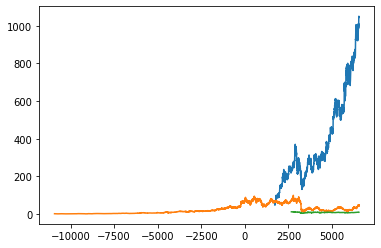

In [10]:
# Los ploteo y veo que hay un tramo en el coinciden las fechas
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
plt.plot(googl_indice,googl_op)
plt.plot(aa_indice,aa_op)
plt.plot(iae_indice,iae_op)

In [11]:
# Me quedo solo las fechas que coinciden
indices = set(googl_indice) & set(aa_indice) & set(iae_indice) 

ii = np.in1d(googl_indice,list(indices))
data_googl = googl_op[ii]
ii = np.in1d(aa_indice,list(indices))
data_aa = aa_op[ii]
ii = np.in1d(iae_indice,list(indices))
data_iae = iae_op[ii]

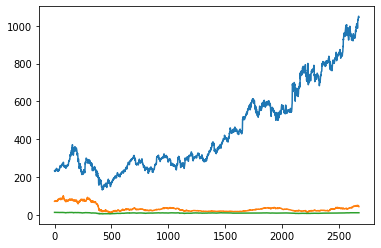

In [12]:
# Los ploteo y ahora síí coinciden en todo el tramo
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
plt.plot(data_googl)
plt.plot(data_aa)
plt.plot(data_iae)

In [13]:
# Los coloco todos juntos en un dataset
DAT = np.zeros((data_googl.shape[0],3))
DAT[:,0] = data_googl
DAT[:,1] = data_aa
DAT[:,2] = data_iae
               

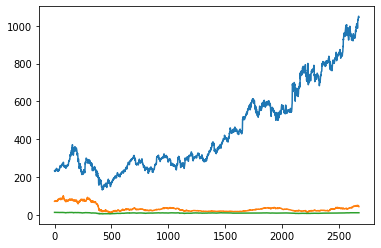

In [14]:
# Los ploteo
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
plt.plot(DAT[:,0])
plt.plot(DAT[:,1])
plt.plot(DAT[:,2])

In [15]:
# Dimensiones del dataset
DAT.shape

(2678, 3)

In [16]:
# Reordeno el dataset para hacer bloques de LAG dias
LAG = 15
DAT_TS = np.zeros((DAT.shape[0]-LAG,LAG,DAT.shape[1]))

for ii in range(0,DAT.shape[0]-LAG):
    DAT_TS[ii,:,:] = DAT[ii:ii+LAG,:]
    

In [17]:
# Tengo (#muestras,#longitud,#variables)
DAT_TS.shape

(2663, 15, 3)

In [18]:
# Cojo 14 dias para entrada y el dia 15 de la variable "Y_target" como variable a predecir
# Separo en train y test

Ntr = np.floor(DAT_TS.shape[0]/2)
Y_target = 0

XX_tr = DAT_TS[range(0,np.int(Ntr)),0:LAG-1,:]
XX_ts = DAT_TS[range(np.int(Ntr)+1,2*np.int(Ntr)),0:LAG-1,:]

YY_tr = DAT_TS[range(0,np.int(Ntr)),LAG-1,Y_target]
YY_ts = DAT_TS[range(np.int(Ntr)+1,2*np.int(Ntr)),LAG-1,Y_target]

LAG-1

14

In [19]:
# Los datos de entrada
XX_tr.shape

(1331, 14, 3)

In [20]:
# Los datos a predecir
YY_tr.shape

(1331,)

KERAS MODEL

In [21]:
# Definimos un modelo con una capa convolucional 1D y 1 capa densa
model = Sequential()
model.add(Conv1D(10, 3, input_shape=XX_tr.shape[1:]))
model.add(Flatten())
model.add(Dense(1))

# mostramos el modelo
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 12, 10)            100       
_________________________________________________________________
flatten (Flatten)            (None, 120)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 121       
Total params: 221
Trainable params: 221
Non-trainable params: 0
_________________________________________________________________


In [22]:
# Otra posibilidad 2 convolucionales 1D y una densa
model = Sequential()
model.add(Conv1D(10, 3, input_shape=XX_tr.shape[1:]))
model.add(Conv1D(10, 3, input_shape=XX_tr.shape[1:]))
model.add(Flatten())
model.add(Dense(1))

# mostramos el modelo
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 12, 10)            100       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 10, 10)            310       
_________________________________________________________________
flatten_1 (Flatten)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 511
Trainable params: 511
Non-trainable params: 0
_________________________________________________________________


In [23]:
# Otra posibilidad 2 convolucionales 1D y 2 densas
model = Sequential()
model.add(Conv1D(10, 3, input_shape=XX_tr.shape[1:]))
model.add(Conv1D(10, 3, input_shape=XX_tr.shape[1:]))
model.add(Flatten())
model.add(Dense(10))
model.add(Dense(1))

# mostramos el modelo
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 12, 10)            100       
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 10, 10)            310       
_________________________________________________________________
flatten_2 (Flatten)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 1,431
Trainable params: 1,431
Non-trainable params: 0
_________________________________________________________________


In [24]:
# Compilamos el modelo
model.compile(optimizer='adam',loss='mae')

In [25]:
# Entrenamos el modelo. Para guardarnos la evolucióón usando callbacks

# from keras.callbacks import History 
# history = History()

# model.fit(XX_tr, YY_tr, batch_size=32, epochs=100, verbose=1, callbacks=[history])

In [26]:
# Entrenamos el modelo, nos guardamos la evolución en 'history' 
# Esto es equivalente a usar callbacks para history
history = model.fit(XX_tr, YY_tr, batch_size=32, epochs=100, verbose=1)

Epoch 1/100
42/42 [==============================] - 0s 2ms/step - loss: 113.3566
Epoch 2/100
42/42 [==============================] - 0s 2ms/step - loss: 14.3688
Epoch 3/100
42/42 [==============================] - 0s 2ms/step - loss: 10.1971
Epoch 4/100
42/42 [==============================] - 0s 2ms/step - loss: 8.6031
Epoch 5/100
42/42 [==============================] - 0s 2ms/step - loss: 8.7968
Epoch 6/100
42/42 [==============================] - 0s 2ms/step - loss: 7.6989
Epoch 7/100
42/42 [==============================] - 0s 2ms/step - loss: 7.5009
Epoch 8/100
42/42 [==============================] - 0s 1ms/step - loss: 7.7683
Epoch 9/100
42/42 [==============================] - 0s 1ms/step - loss: 9.3902
Epoch 10/100
42/42 [==============================] - 0s 2ms/step - loss: 7.4143
Epoch 11/100
42/42 [==============================] - 0s 1ms/step - loss: 6.9746
Epoch 12/100
42/42 [==============================] - 0s 1ms/step - loss: 7.4276
Epoch 13/100
42/42 [=============

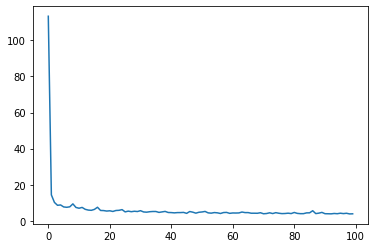

In [27]:
# Mostramos la evolucióón del entrenamiento
loss_ev = history.history['loss']

import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
plt.plot(loss_ev)

In [28]:
# Evaluamos el modelo en train
score = model.evaluate(XX_tr, YY_tr, verbose=0)
score

4.187546730041504

In [29]:
# Predecimos con los datos de train
y_hat = model.predict(XX_tr)
np.mean(abs(y_hat[:,0]-YY_tr))

4.187546169358389

In [30]:
y_hat.shape

(1331, 1)

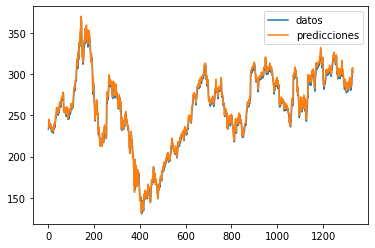

In [31]:
# Mostramos las predicciones
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
plt.plot(y_hat, label='datos')
plt.plot(YY_tr, label='predicciones')
plt.legend()

TEST

In [32]:
# Predecimos en test
y_hat = model.predict(XX_ts)
# mostramos el error
np.mean(abs(y_hat[:,0]-YY_ts))

10.396066507210412

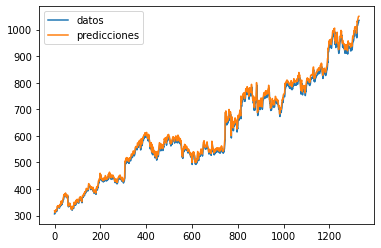

In [33]:
# Mostramos las predicciones
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
plt.plot(y_hat, label='datos')
plt.plot(YY_ts, label='predicciones')
plt.legend()

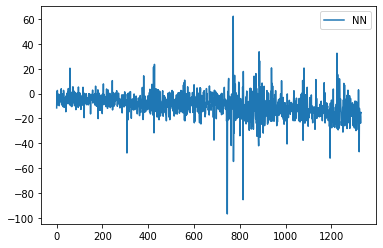

In [34]:
# Estas son las diferencias
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
plt.plot(y_hat[:,0]-YY_ts, label='NN')
plt.legend()